In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import random
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense,LeakyReLU
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras import Sequential
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.random import set_seed
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

SEED=21
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

#Preprocessing

Loading Preprocessed Data

In [ ]:
# Features have been previously extracted and saved as a numpy array.
# Details of this feature extraction is written in the report.
X_saving_path = '/content/drive/MyDrive/ML/FP_data_cleaned/X.npy'

# CSV file has been cleaned of problematic IDs.
# The cleaned dataframe has been saved as a numpy array in the following directory.
labels_saving_path = '/content/drive/MyDrive/ML/FP_data_cleaned/labels_.npy'

X = np.load(X_saving_path)
# column1: emotionsID; column2: textID; column3: sex
# column4: age; column5: voice ID
labels=np.load(labels_saving_path, allow_pickle=True)

Further Cleanings

In [ ]:
# We need some further cleanings here.
# We are about to classify genders and emotions;
# So we have to make sure our labels are correct.

emotion = labels[:,0]
print(Counter(emotion))

gender = labels[:,2]
print(Counter(gender))


Counter({3: 4177, 4: 4177, 1: 4166, 2: 4144, 10: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20})
Counter({'m': 8182, 'f': 7557, 'M': 503, 'F': 382, 'w': 80, 'f ': 80})


In [ ]:
# As you see, labels for emotions are not right (we should only have 4 emotions).
# So we will clean our data out of these uncorrect labels.

ii = np.where(emotion<5)
X = X[ii]
labels = labels[ii]
emotion = labels[:,0]
gender = labels[:,2]
id_txt = labels[:,1]
id_voice = labels[:,-1]

# Now we have to clean label for gender.
# We will 'm' for man and 'f' for woman.
jj=np.where(gender=='M')
gender[jj]='m'
jj=np.where(gender!='m')
gender[jj]='f'

print(Counter(emotion))
print(Counter(gender)) #Unbalancy is neglegible

emotion=emotion.astype(int)
gender=gender.astype(str)

Counter({3: 4177, 4: 4177, 1: 4166, 2: 4144})
Counter({'m': 8637, 'f': 8027})


Test-Train Split

In [ ]:
IDs_idx = list(range(emotion.size))

train_size = int(emotion.size*0.7)

# This is how we made sure there is at least one person whose 
# voice is not present in the test dataset at all

train_idx = np.random.choice(IDs_idx[40:],train_size,replace=False)
test_idx = list(set(IDs_idx)-set(list(train_idx)))

X_train = X[train_idx]
emotion_train = emotion[train_idx]
gender_train = gender[train_idx]

X_test = X[test_idx]
emotion_test = emotion[test_idx]
gender_test = gender[test_idx]

Different Xs with Different Features 

In [ ]:
#X_train
#X_test

X_train_f1=X_train[:,10:25] #frequency
X_test_f1=X_test[:,10:25]

X_train_f2=X_train[:,np.r_[-80:-40]] #spectral
X_test_f2=X_test[:,np.r_[-80:-40]]

#----
X_train_f3=X_train[:,:4] #time
X_test_f3=X_test[:,:4]


#Functions

Plotting ROC

In [ ]:
#Credit:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def ROC_plot(clf,XX_test,YY_test,classes):
  #YY_score_bi = clf.decision_function(XX_test)
  try:
    YY_score_bi = clf.decision_function(XX_test)
  except AttributeError:
    YY_score_bi = clf.predict_proba(XX_test)
  lw = 2
  n_classes=len(classes)
  YY_test_bi=label_binarize(YY_test, classes=classes)
  
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(YY_test_bi[:, i], YY_score_bi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  fpr["micro"], tpr["micro"], _ = roc_curve(YY_test_bi.ravel(), YY_score_bi.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
      color="navy",
      linestyle=":",
      linewidth=4,
  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC: Emotion Classification")
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def ROC_2classes(clf,XX_test,YY_test,classes):
  try:
    YY_score_bi = clf.decision_function(XX_test)
  except AttributeError:
    YY_score_bi = clf.predict_proba(XX_test)[:,1]
  lw = 2
  n_classes=len(classes)
  YY_test_bi=label_binarize(YY_test, classes=classes)

  
  fpr, tpr, _ = roc_curve(YY_test_bi, YY_score_bi)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC: Gender Classification")
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def ConfMat_plot(YY_test,YY_pred,classes):
  cm=confusion_matrix(YY_test, YY_pred, labels=classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

In [ ]:
def Report(clf,XX_test,YY_test,YY_pred,classes):
  str_classes=[str(class_) for class_ in classes]
  print(classification_report(YY_test, YY_pred))
  if len(classes)==2:
    print(1)
    ROC_2classes(clf,XX_test,YY_test,classes)
  else:
    ROC_plot(clf,XX_test,YY_test,classes)
  ConfMat_plot(YY_test,YY_pred,classes)

In [ ]:
def fit_pred(clf,XX_train,YY_train,XX_test,YY_test,classes):
  clf.fit(XX_train, YY_train)
  YY_pred = clf.predict(XX_test)
  acc_test=accuracy_score(YY_test,YY_pred)
  print('Test accuracy score is: ', acc_test)
  YY_train_pred = clf.predict(XX_train)
  acc_train=accuracy_score(YY_train,YY_train_pred)
  print('Train accuracy score is: ', acc_train)
  Report(clf,XX_test,YY_test,YY_pred,classes)
  return YY_pred, YY_train_pred

#Classification: SVM

**A-0: Gender Classification**
: All extracted features were used

Test accuracy score is:  0.9276
Train accuracy score is:  0.9542181069958847
              precision    recall  f1-score   support

           f       0.92      0.92      0.92      2315
           m       0.93      0.93      0.93      2685

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000

1


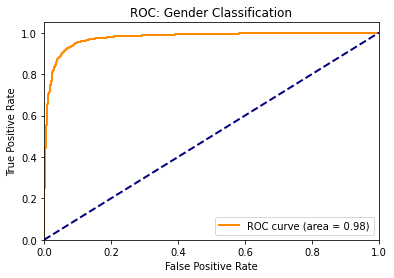

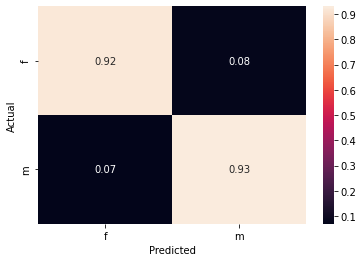

In [ ]:
gender_classes=['f','m']
clf = make_pipeline(StandardScaler(), SVC())
gender_pred, gender_train_pred = fit_pred(clf,X_train,gender_train,X_test,gender_test,gender_classes)

**A-1: Gender Classification** : Features set 1 was used

Test accuracy score is:  0.7196
Train accuracy score is:  0.7495713305898491
              precision    recall  f1-score   support

           f       0.71      0.68      0.69      2315
           m       0.73      0.76      0.74      2685

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000

1


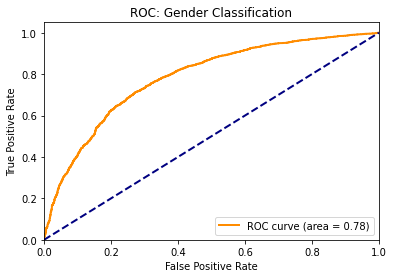

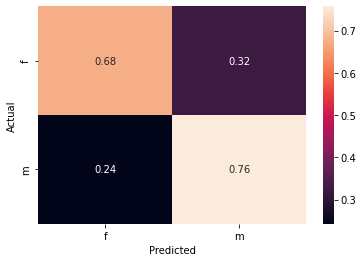

In [ ]:
gender_classes=['f','m']
clf = make_pipeline(StandardScaler(), SVC())
gender_pred, gender_train_pred = fit_pred(clf,X_train_f1,gender_train,X_test_f1,gender_test,gender_classes)

**A-2: Gender Classification** : Features set 2 was used

Test accuracy score is:  0.923
Train accuracy score is:  0.9474451303155007
              precision    recall  f1-score   support

           f       0.92      0.92      0.92      2315
           m       0.93      0.93      0.93      2685

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000

1


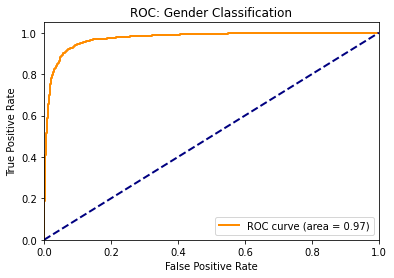

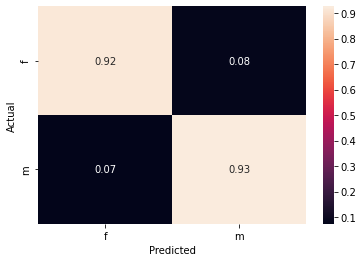

In [ ]:
gender_classes=['f','m']
clf = make_pipeline(StandardScaler(), SVC())
gender_pred, gender_train_pred = fit_pred(clf,X_train_f2,gender_train,X_test_f2,gender_test,gender_classes)

**A-3: Gender Classification:** Feature set 3 was used (extra)

Test accuracy score is:  0.617
Train accuracy score is:  0.6262002743484225
              precision    recall  f1-score   support

           f       0.58      0.65      0.61      2315
           m       0.66      0.59      0.62      2685

    accuracy                           0.62      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.62      0.62      0.62      5000

1


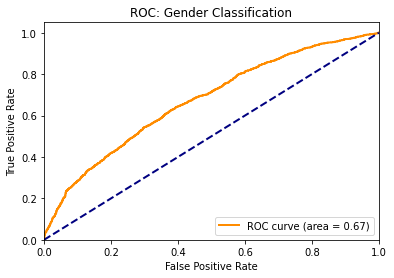

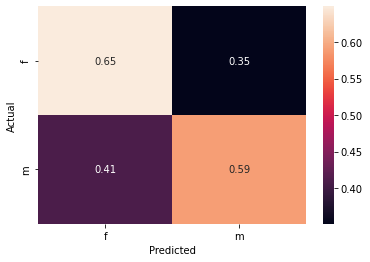

In [ ]:
gender_classes=['f','m']
clf = make_pipeline(StandardScaler(), SVC())
gender_pred, gender_train_pred = fit_pred(clf,X_train_f3,gender_train,X_test_f3,gender_test,gender_classes)

**B-0: Emotion Classification** : All extracted features were used

Test accuracy score is:  0.5298
Train accuracy score is:  0.6604938271604939
              precision    recall  f1-score   support

           1       0.56      0.62      0.59      1208
           2       0.62      0.51      0.56      1298
           3       0.51      0.53      0.52      1240
           4       0.45      0.48      0.46      1254

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.53      5000
weighted avg       0.53      0.53      0.53      5000



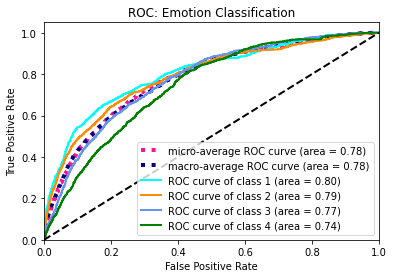

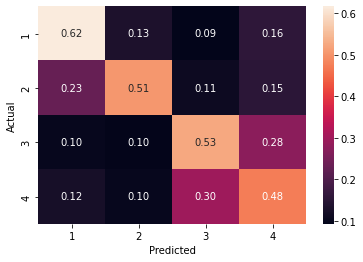

In [ ]:
emotion_classes = [1,2,3,4]
clf = make_pipeline(StandardScaler(), SVC())
emotion_pred, emotion_train_pred = fit_pred(clf,X_train,emotion_train,X_test,emotion_test,emotion_classes)

**B-1: Emotion Classification** : Features set 1 was used.

Test accuracy score is:  0.403
Train accuracy score is:  0.4885973936899863
              precision    recall  f1-score   support

           1       0.41      0.59      0.48      1208
           2       0.46      0.27      0.34      1298
           3       0.41      0.41      0.41      1240
           4       0.36      0.35      0.35      1254

    accuracy                           0.40      5000
   macro avg       0.41      0.41      0.40      5000
weighted avg       0.41      0.40      0.40      5000



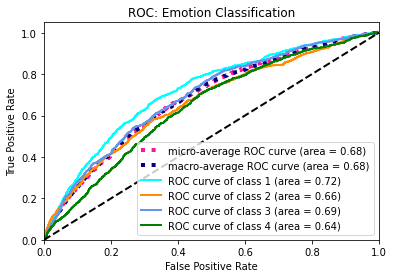

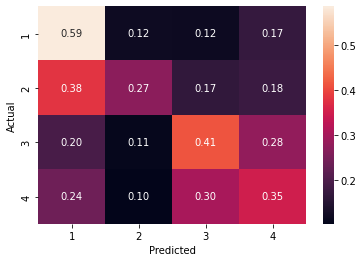

In [ ]:
emotion_classes = [1,2,3,4]
clf = make_pipeline(StandardScaler(), SVC())
emotion_pred, emotion_train_pred = fit_pred(clf,X_train_f1,emotion_train,X_test_f1,emotion_test,emotion_classes)

**B-2: Emotion Classification** : Features set 2 was used.

Test accuracy score is:  0.507
Train accuracy score is:  0.6676954732510288
              precision    recall  f1-score   support

           1       0.54      0.56      0.55      1208
           2       0.59      0.51      0.54      1298
           3       0.49      0.52      0.51      1240
           4       0.42      0.44      0.43      1254

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000



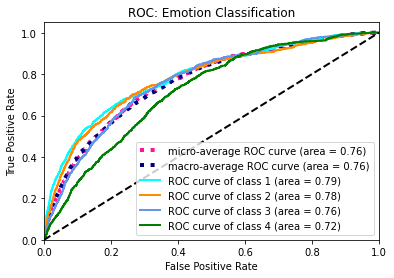

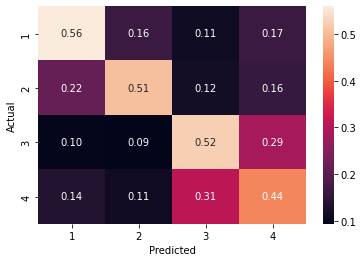

In [ ]:
emotion_classes = [1,2,3,4]
clf = make_pipeline(StandardScaler(), SVC())
emotion_pred, emotion_train_pred = fit_pred(clf,X_train_f2,emotion_train,X_test_f2,emotion_test,emotion_classes)

#Classification: Random Forest

**A-0: Gender Classification**
: All extracted features were used

Test accuracy score is:  0.896
Train accuracy score is:  1.0
              precision    recall  f1-score   support

           f       0.89      0.89      0.89      2315
           m       0.90      0.91      0.90      2685

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

1


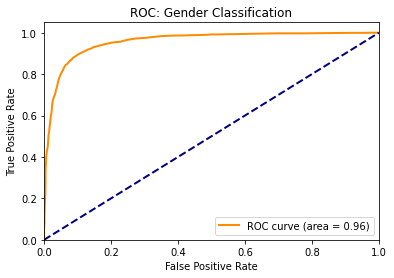

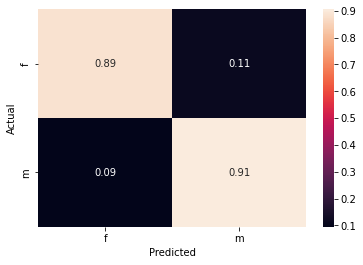

In [ ]:
gender_classes=['f','m']
clf = RandomForestClassifier()
gender_pred, gender_train_pred = fit_pred(clf,X_train,gender_train,X_test,gender_test,gender_classes)

**A-1: Gender Classification** : Features set 1 was used

Test accuracy score is:  0.714
Train accuracy score is:  1.0
              precision    recall  f1-score   support

           f       0.69      0.70      0.69      2315
           m       0.74      0.73      0.73      2685

    accuracy                           0.71      5000
   macro avg       0.71      0.71      0.71      5000
weighted avg       0.71      0.71      0.71      5000

1


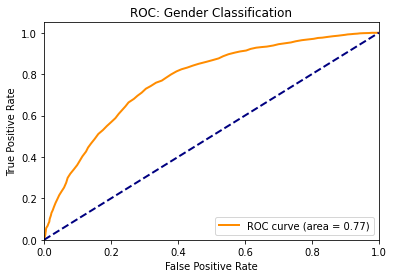

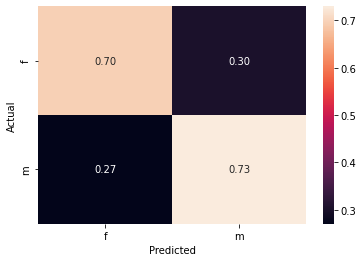

In [ ]:
gender_classes=['f','m']
clf = RandomForestClassifier()
gender_pred, gender_train_pred = fit_pred(clf,X_train_f1,gender_train,X_test_f1,gender_test,gender_classes)

**A-2: Gender Classification** : Features set 2 was used

Test accuracy score is:  0.882
Train accuracy score is:  1.0
              precision    recall  f1-score   support

           f       0.87      0.87      0.87      2315
           m       0.89      0.89      0.89      2685

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

1


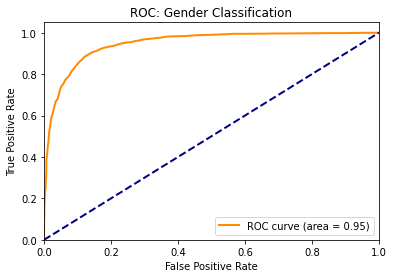

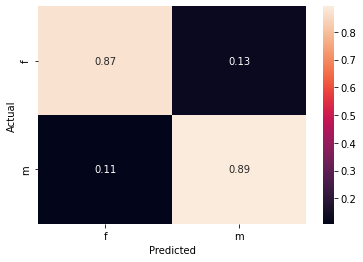

In [ ]:
gender_classes=['f','m']
clf = RandomForestClassifier()
gender_pred, gender_train_pred = fit_pred(clf,X_train_f2,gender_train,X_test_f2,gender_test,gender_classes)

**B-0: Emotion Classification** : All extracted features were used

Test accuracy score is:  0.5008
Train accuracy score is:  0.9987139917695473
              precision    recall  f1-score   support

           1       0.53      0.58      0.55      1208
           2       0.55      0.48      0.51      1298
           3       0.49      0.53      0.51      1240
           4       0.43      0.42      0.43      1254

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



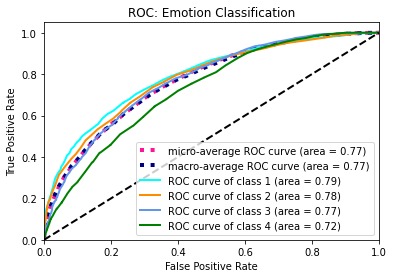

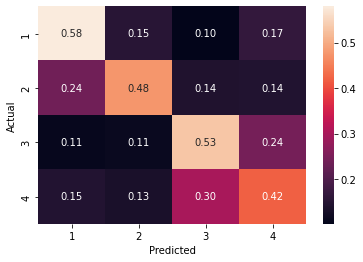

In [ ]:
emotion_classes = [1,2,3,4]
clf = RandomForestClassifier()
emotion_pred, emotion_train_pred = fit_pred(clf,X_train,emotion_train,X_test,emotion_test,emotion_classes)

**B-1: Emotion Classification** : Features set 1 was used.

Test accuracy score is:  0.4046
Train accuracy score is:  0.9987139917695473
              precision    recall  f1-score   support

           1       0.42      0.56      0.48      1208
           2       0.45      0.32      0.37      1298
           3       0.40      0.44      0.42      1240
           4       0.35      0.31      0.33      1254

    accuracy                           0.40      5000
   macro avg       0.40      0.41      0.40      5000
weighted avg       0.41      0.40      0.40      5000



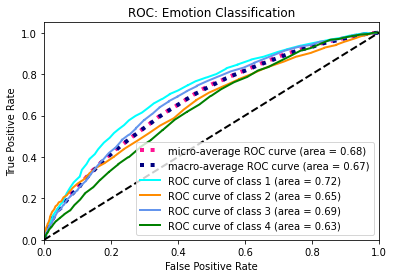

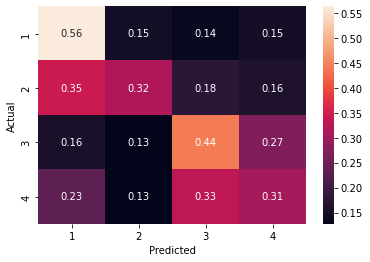

In [ ]:
emotion_classes = [1,2,3,4]
clf = RandomForestClassifier()
emotion_pred, emotion_train_pred = fit_pred(clf,X_train_f1,emotion_train,X_test_f1,emotion_test,emotion_classes)

**B-2: Emotion Classification** : Features set 2 was used.

Test accuracy score is:  0.477
Train accuracy score is:  0.9987139917695473
              precision    recall  f1-score   support

           1       0.50      0.55      0.53      1208
           2       0.55      0.48      0.51      1298
           3       0.45      0.50      0.47      1240
           4       0.40      0.37      0.39      1254

    accuracy                           0.48      5000
   macro avg       0.48      0.48      0.48      5000
weighted avg       0.48      0.48      0.48      5000



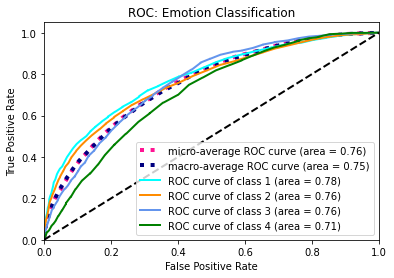

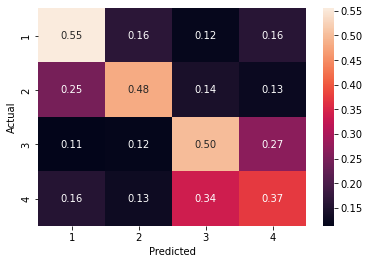

In [ ]:
emotion_classes = [1,2,3,4]
clf = RandomForestClassifier()
emotion_pred, emotion_train_pred = fit_pred(clf,X_train_f2,emotion_train,X_test_f2,emotion_test,emotion_classes)